In [1]:
import warnings

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_pickle, moving_average
from analyze_tools.monte_carlo import get_colliding_time
#from analyze_tools.utils import field_spectra, DipoleSpectra
import analyze_tools.utils as spectra_utils

import animation as an
from analyze_tools.IR_DACF import calc_FFT, calc_ACF, calc_derivative
import analyze_tools.utils as atu

import gc


In [9]:
#
# Define paths to pickle files
# Defining functions
#

linestyle_list = ["solid", "dashed", "dotted","dashdot"]
scatter_list = ["o", "^","v"]

ROOT = os.path.expanduser('~/OneDrive - Emory/Research Data/mm_polariton/pickle_jar/')
ROOT2 = ROOT

# define lists of temperature
temperature_list = ['292.0', '200.0', '100.0']
#seed_list = [715, 82] # seed for free field case, the order match temperature_list
seed_list = [2928, 82, 1008] # seed for free field case, the order match temperature_list
seed_list2 = [100810,100115,100120] # seed for cavity field case, the order match c_list
c_list = ['Lxy1e1', "Lxy15", "Lxy2e1"] #

seed_list3 = [8100110, 8100115, 8100120]
c_list2 = ['Lxy1e1', 'Lxy15', 'Lxy2e1']

# define patterns of paths that lead to pickle file
freefield_path = lambda t,s: ROOT2 + "free-{}_256_{}-zero_0_0".format(t,s)
cavityfield_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityboltzmann_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)

for i, temp in enumerate(temperature_list):
    atu.check_path(freefield_path(temp, seed_list[i]))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_path('100.0', seed_list2[i], c))

for i, c in enumerate(c_list2):
    atu.check_path(cavityboltzmann_path('100.0', seed_list3[i], c))

fig_root = "figure/manuscript/"
if not os.path.isdir(fig_root):
    os.mkdir(fig_root)

FREEFIELD_RESULT_DICT = { # result in free field path
    temp: freefield_path(temp,seed_list[i])
    for i, temp in enumerate(temperature_list)
}
CAVITYFIELD_RESULT_DICT2 = { # result in cavity field path
    c: cavityfield_path('100.0',seed_list2[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_DICT3 = { # result in cavity field path
    c: cavityboltzmann_path('100.0',seed_list3[i], c)
    for i, c in enumerate(c_list2)
}

def getall_colliding_time(result_dict_path, limit = None):
    directory_dict = categorizing_pickle(result_dict_path, '')
    
    all_colliding_time = np.array([])
    
    for i, (j, path) in enumerate(directory_dict.items()):
        if limit and i > limit: 
            continue

        with open(path, 'rb') as handle:
            result_dict = pickle.load(handle)
            
        atoms = result_dict['atoms']
        
        time = get_colliding_time(atoms, dipole_threshold = 0)
    
        all_colliding_time = np.hstack([all_colliding_time, time])

        del result_dict
        
    return all_colliding_time


/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


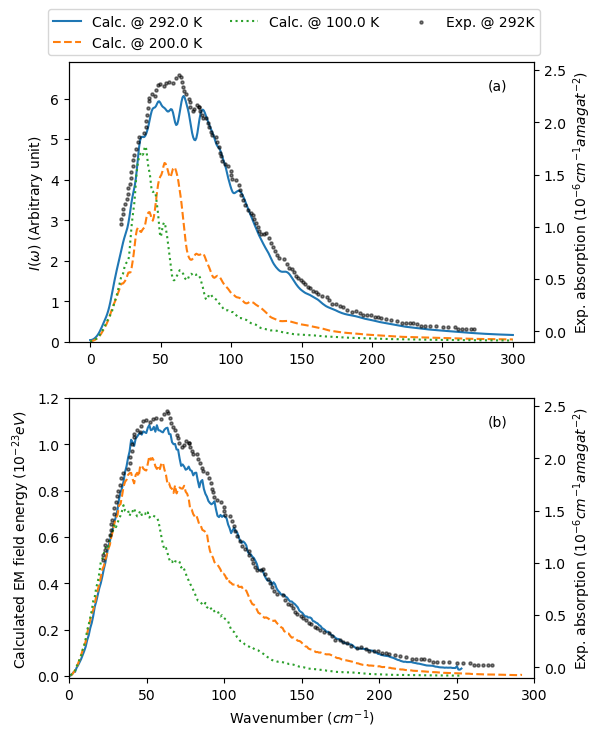

In [22]:
## from copy import deepcopy

fig,ax = plt.subplots(2, figsize = (6,8))

for i in [0,1]:
    # plotting the experimental dataset
    tax = ax[i].twinx()
    exp_data = pd.read_csv('data/plot-data.csv')
    tax.scatter(
        exp_data.loc[:,'x'],
        exp_data.loc[:,' y'],
        s = 5, alpha = 0.5, c = 'black', 
        label = 'Exp. @ 292K' if i == 0 else None
    )
    tax.set_ylabel(r'Exp. absorption $(10^{-6} cm^{-1} amagat^{-2})$')

for i,(temp, freefield_result_path) in enumerate(FREEFIELD_RESULT_DICT.items()):
    
    dipole_spec = spectra_utils.DipoleSpectra(
        dtps = 1e-2, convert_function = {'time': red.convert_time})

    # loop over all pickle file in the directory to calculate the mean spectrum
    # copy from here
    
    directory_dict = categorizing_pickle(freefield_result_path, '')

    rad_profile = []
    for _, (j, path) in enumerate(directory_dict.items()):
        
        with open(path, 'rb') as handle:
            freefield_result_dict = pickle.load(handle)

        dipole_spec.add_result_dict(freefield_result_dict)
          
        omega_profile, rad_profile1 = spectra_utils.field_spectra(
            freefield_result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber}
        ) 
        rad_profile.append(rad_profile1)

        del freefield_result_dict

    rad_profile = np.mean(rad_profile, axis = 0)
    rad_profile *= 1e23
    o, f = moving_average(omega_profile, rad_profile, w = 10)
    ax[1].plot(o, f, label = "Calc. @ {} K".format(temp), linestyle = linestyle_list[i])
    # to here for rad profile - end of copy

    w, spec = dipole_spec()
    spec = np.mean(spec, axis = 0)
    spec *= 1e5
    spec = spec[ w < 300 ]
    w = w[w < 300]
    # to here for dipole spectra - end of copying
    
    ax[0].plot(w, spec, linestyle = linestyle_list[i]) 
    
    if temp == '292.0':
        rad_profile292 = f
        omega_profile292 = o
        
    
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)

ax[1].set_xlim(0,300)
ax[0].set_ylim(-0.01,6.9)
ax[1].set_ylim(-0.01,1.2)
ax[0].set_ylabel(r"$I(\omega)$ (Arbitrary unit)")
ax[1].set_ylabel(r"Calculated EM field energy $(10^{-23} eV)$")
ax[1].set_xlabel(r"Wavenumber $(cm^{-1})$")

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + "free_spectrum.jpeg",dpi = 600, bbox_inches = 'tight')

/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


83251

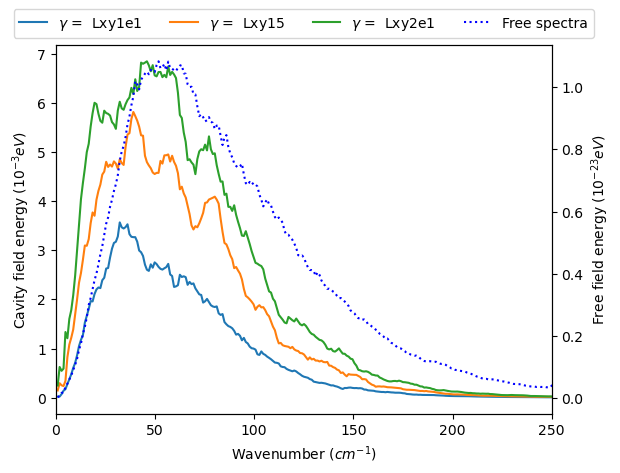

In [37]:
fig,ax = plt.subplots()

for i, (temp, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):

    directory_dict = categorizing_pickle(cavityfield_result_path, '')

    rad_profile = []
    for _, (j, path) in enumerate(directory_dict.items()):
        
        with open(path, 'rb') as handle:
            result_dict = pickle.load(handle)

        dipole_spec.add_result_dict(result_dict)
          
        omega_profile, rad_profile1 = spectra_utils.field_spectra(
            result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber}
        ) 
        rad_profile.append(rad_profile1)

        del result_dict

    rad_profile = np.mean(rad_profile, axis = 0)
    rad_profile *= 1e3
    o, f = moving_average(omega_profile, rad_profile, w = 10)
    ax.plot(o, f, label = r"$\gamma$ =  {}".format(temp))
    # to here for rad profile - end of copy

ax.plot(
    [], [], label = "Free spectra" , 
    linestyle = linestyle_list[2],color='b'
)
ax.set_xlim(0, 250)

tax = ax.twinx()
tax.plot(
    omega_profile292, rad_profile292, 
    label = "Free field spectra @ 200K", 
    linestyle = linestyle_list[2], color= 'b'
)
tax.set_xlim(0, 250)


ax.set_ylabel(r"Cavity field energy ($10^{-3} eV$)")
tax.set_ylabel(r"Free field energy ($10^{-23} eV$)")

#ax.set_xlim(0,300)
ax.set_xlabel(r'Wavenumber ($cm^{-1}$)')

ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=4)

fig.savefig(fig_root + "cavity_spectrum.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

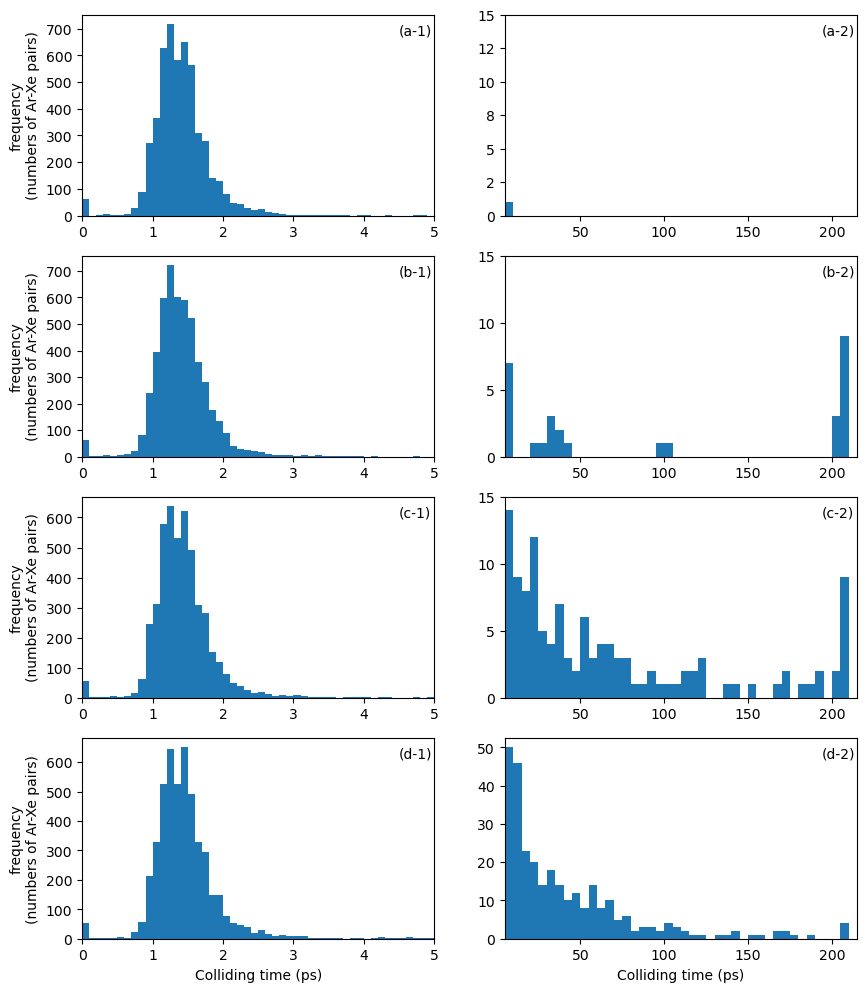

In [34]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

freefield_result_dict = FREEFIELD_RESULT_DICT['100.0']

ft = getall_colliding_time(freefield_result_dict, limit = 0)

fig,ax = plt.subplots(4,2, figsize = (10,12))

ax[0,0].hist(ft, np.arange(0,5 + 0.1, 0.1))
ax[0,1].hist(ft, np.arange(5,215,5))

del ft
del freefield_result_dict

bin_dict = {}

for i, coup_str in enumerate(['Lxy1e1', 'Lxy15', 'Lxy2e1']):
    i += 1
    
    cavityfield_result_dict = CAVITYFIELD_RESULT_DICT2[coup_str]
    ct = getall_colliding_time(cavityfield_result_dict, limit = 0)

    bin1 = ax[i,0].hist(ct, np.arange(0,5 + 0.1, 0.1))
    bin2 = ax[i,1].hist(ct, np.arange(5,215,5))

    bin_dict.update({coup_str: (bin1, bin2)})

    del ct
    del cavityfield_result_dict

    if np.max(bin2[0]) > 30:
        ax[i,1].yaxis.set_major_locator(MultipleLocator(10))
    else:
        ax[i,1].yaxis.set_major_locator(MultipleLocator(5))

for i in range(4):
    ax[i,0].yaxis.set_major_locator(MultipleLocator(100))
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')
    
    ax[i,0].set_xlim(0,5)
    ax[i,1].set_xlim(5,215)
    
    ax[i,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')

    if i < 3:
        ax[i,1].set_ylim(0,15)

ax[3,0].set_xlabel('Colliding time (ps)')
ax[3,1].set_xlabel('Colliding time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1,0].annotate('(b-1)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2,0].annotate('(c-1)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[3,0].annotate('(d-1)',xy = (0.9,0.9), xycoords = 'axes fraction')

ax[0,1].annotate('(a-2)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1,1].annotate('(b-2)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2,1].annotate('(c-2)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[3,1].annotate('(d-2)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + 'histogram.jpeg',dpi=600, bbox_inches = 'tight')

In [25]:
np.max( bin_dict['Lxy1e1'][1][0] )

14.0

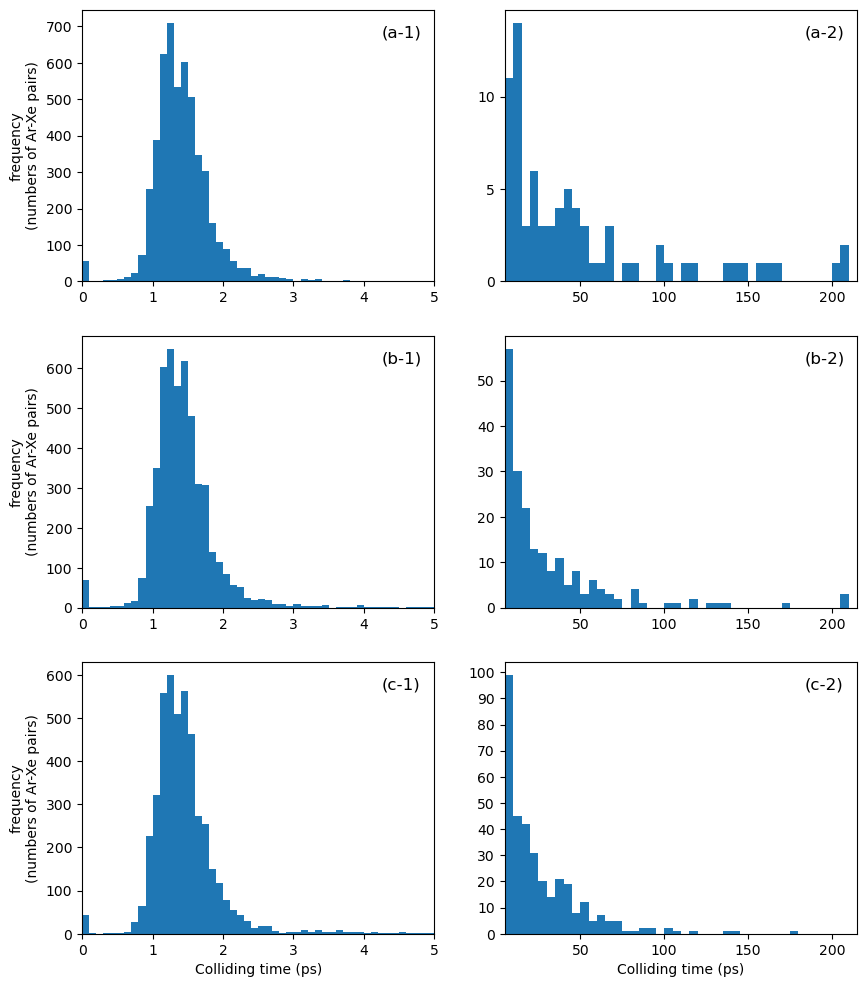

In [33]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

fig,ax = plt.subplots(3,2, figsize = (10,12))

bin_dict = {}

for i, coup_str in enumerate(['Lxy1e1', 'Lxy15', 'Lxy2e1']):
    
    cavityfield_result_dict = CAVITYFIELD_RESULT_DICT3[coup_str]
    ct = getall_colliding_time(cavityfield_result_dict, limit = 0)

    bin1 = ax[i,0].hist(ct, np.arange(0,5 + 0.1, 0.1))
    bin2 = ax[i,1].hist(ct, np.arange(5,215,5))
    
    bin_dict.update({coup_str: (bin1, bin2)})

    del ct
    del cavityfield_result_dict

    if np.max(bin2[0]) > 30:
        ax[i,1].yaxis.set_major_locator(MultipleLocator(10))
    else:
        ax[i,1].yaxis.set_major_locator(MultipleLocator(5))
        
for i in range(3):
    
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')
    
    ax[i,0].set_xlim(0,5)
    ax[i,1].set_xlim(5,215)
    
    ax[i,0].set_ylabel('frequency\n(numbers of Ar-Xe pairs)')


ax[2,0].set_xlabel('Colliding time (ps)')
ax[2,1].set_xlabel('Colliding time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate('(b-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[2,0].annotate('(c-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')

ax[0,1].annotate('(a-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate('(b-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[2,1].annotate('(c-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')

fig.savefig(fig_root + 'histogram_boltzmann.jpeg',dpi=600, bbox_inches = 'tight')

In [39]:
cavityfield_result_dict2 = categorizing_pickle(
    CAVITYFIELD_RESULT_DICT2['Lxy15'], ''
)
with open(cavityfield_result_dict2[1],'rb') as handle:
    cavityfield_result_dict2 = pickle.load(handle)

In [42]:
atoms = cavityfield_result_dict2['atoms']
coltime = np.array(get_colliding_time(atoms, 0))
result_idx = np.argmax(coltime)
print(coltime[result_idx])

field = cavityfield_result_dict2['field']
atoms = cavityfield_result_dict2['atoms']

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,result_idx]
r_xe = np.array(atoms.trajectory['r'])[:,result_idx + N_pairs]

v_ar = np.array(atoms.trajectory['r_dot'])[:,result_idx]
v_xe = np.array(atoms.trajectory['r_dot'])[:,result_idx + N_pairs]

t = np.array(atoms.trajectory['t'])

200.82070070832955


/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


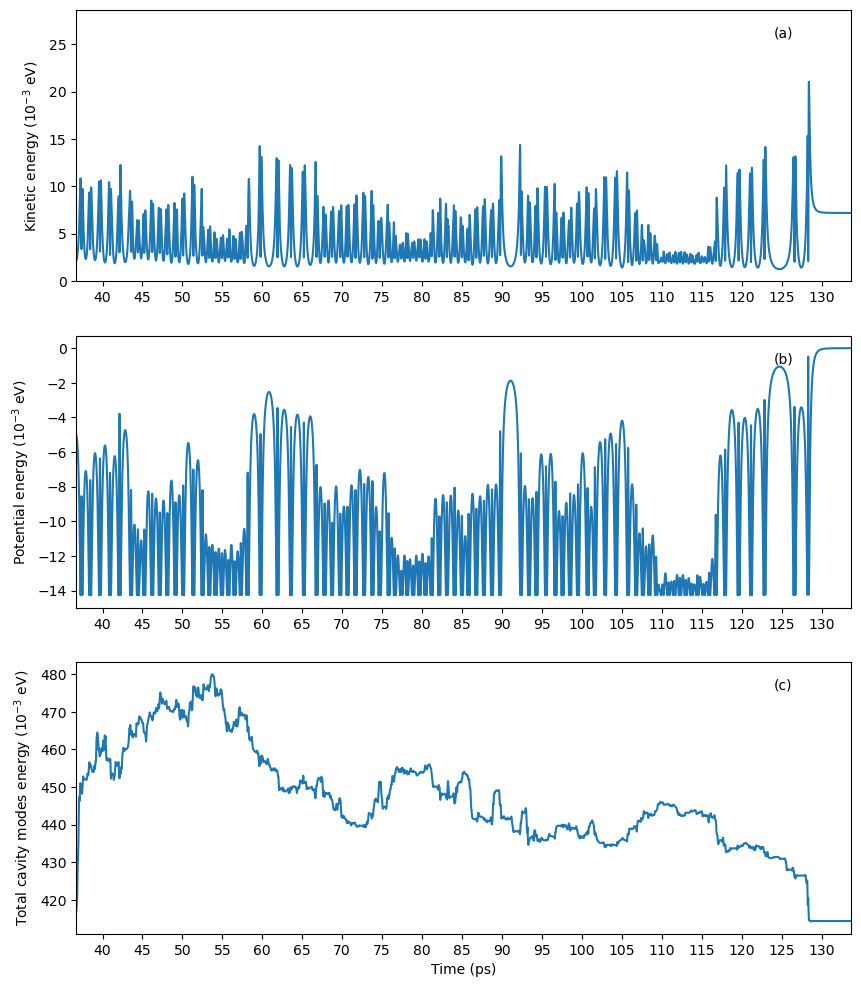

In [43]:
from calculator.function import LJ_potential

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = field.history['t']

fig,ax = plt.subplots(3,figsize = (10,12))
#ax[0].plot(t[200:], d[200:])
ax[0].plot(t, k)
ax[1].plot(t, v)
ax[2].plot(tem[300:], hem[300:])

#ax[0].set_xlim(t[0],t[-1])
ax[0].set_xlim(t[300],t[-1])
ax[1].set_xlim(t[300],t[-1])
ax[2].set_xlim(tem[300],tem[-1])

ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_major_formatter('{x:.0f}')

ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_major_formatter('{x:.0f}')

ax[2].xaxis.set_major_locator(MultipleLocator(5))
ax[2].xaxis.set_major_formatter('{x:.0f}')

#ax[0].set_ylabel(r'Ar-Xe distance (nm)')
ax[0].set_ylabel(r'Kinetic energy ($10^{-3}$ eV)')
ax[1].set_ylabel(r'Potential energy ($10^{-3}$ eV)')
ax[2].set_ylabel(r'Total cavity modes energy ($10^{-3}$ eV)')

ax[2].set_xlabel('Time (ps)')

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + 'energy_breakdown.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
wn_list = red.convert_wavenumber(field.k_val)

In [ ]:
fig,ax = plt.subplots(3,figsize = (8,12))

hem = np.array(field.history['energy'])

t0 = 190; tf = 205
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[0].plot(x, y)
ax[0].vlines(22.766, min(y), max(y), linestyle = 'dotted')

t0 = 250; tf = 275
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[1].plot(x,y)
ax[1].vlines(22.766, min(y), max(y), linestyle = 'dotted')

t0 = 230; tf = 240
y = np.std(hem[(t > t0) * (t < tf), :], axis = 0)
x, y = pt.moving_average(wn_list, y, 10)
ax[2].plot(x,y)
ax[2].vlines(22.766, min(y), max(y), linestyle = 'dotted')


In [ ]:
an = importlib.reload(an)

an.single_anime(atoms, index = i , N_pairs = N_pairs, save_path = 'figure2/longest_anime')

In [ ]:
for i, (temp, result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):

    if i == 0: continue
    result_dict = categorizing_result(result_path)

    for j in result_dict.keys():
        atoms = result_dict[j]['atoms']
        field = result_dict[j]['field']
    
        k = np.array(atoms.observable['kinetic'])
        v = np.array(atoms.observable['potential'])
        
        hrad = np.sum(field.history['energy'], axis = 1)
        t = field.history['t']
        
        total = k + v + hrad
        print(red.convert_energy(
            (total[0] - total[-1]) / (512*3 + 300 * 2)
            ,'ev'
        ))

In [ ]:
red.convert_energy(1 / (512 * 3 + 300) , 'ev')

In [ ]:
fig,ax = plt.subplots(3, figsize = (6,12))

foo = [5,12,14]

for i, (cs, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):
    
    cavityfield_result_dict = categorizing_result(CAVITYFIELD_RESULT_DICT2[cs], '')
    
    wn, spec1 = dipole_spectra(cavityfield_result_dict, 1e-2,time_frame = (5.0, np.inf), windows = 'Gaussian')
    
    #w, s = pt.moving_average(wn_real, spec1, w = 2)
    spec1 = np.mean(spec1, axis = 0)
    spec1 = spec1[wn < 75] * 1e6
    wn = wn[wn < 75]
    ax[i].plot(wn, spec1, label = "T = {} K".format(temp))
    ax[i].vlines(vib_freq, min(spec1), max(spec1), linestyle = 'dotted')
    
    del cavityfield_result_dict

ax[0].set_ylabel("Emission (Arbitrary unit)")
ax[1].set_ylabel("Emission (Arbitrary unit)")
ax[2].set_ylabel("Emission (Arbitrary unit)")
ax[1].set_xlabel("Wavenumber $(cm^{-1})$")

ax[0].annotate('(a)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.9,0.9), xycoords = 'axes fraction')
ax[2].annotate('(c)',xy = (0.9,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + "cavity_spectrum_peak.jpeg",dpi = 600,bbox_inches = 'tight')